In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from lifetimes.utils import summary_data_from_transaction_data
import numpy as np
import datetime
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from lifetimes import ModifiedBetaGeoFitter
from lifetimes import GammaGammaFitter
import dask.dataframe as dd
from dask.multiprocessing import get
from collections import Counter
from sklearn.model_selection import train_test_split
import gc
import joblib
import boto3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
config = tf.ConfigProto(device_count={"CPU": 20})
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import Dropout
from sklearn.utils import class_weight
from sklearn.model_selection import RandomizedSearchCV, KFold
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras import layers
from keras import Input
from keras.layers import BatchNormalization
from sklearn.model_selection import ParameterSampler
from scipy.stats.distributions import expon
from keras.models import load_model
import io
import json
from keras_preprocessing.text import tokenizer_from_json

debug = True

Using TensorFlow backend.


In [3]:
def _write_dataframe_to_csv_on_s3(df, path_s3):
    import boto3
    from io import StringIO
    """ Write a dataframe to a CSV on S3 """
    a = path_s3.split('//')
    b = a[1].split('/')
    bucket = b[0]
    c = path_s3.split(bucket+'/')
    path = c[1]
    
    buffer = StringIO()
    df.to_csv(buffer,index=False)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(bucket, path).put(Body=buffer.getvalue())
    return None

In [4]:
def asigno_quintiles_6(x):
    step = int(x.shape[0]*0.1) # segmentos de 10%
    
    l_ = []
    for i in range(6):  # asigno los primeros 50% en segmentos de 10%
        l_ = l_ + ["q"+str(i+1)]*step    
    
    step2 = x.shape[0] - len(l_)
    l_ = l_ + ["q6"]*step2
    return l_

## Exploro el doc2vec

In [97]:
data = pd.read_csv("s3://fda-labs/ltv-ml/Embedding/preproc_Doc2vec/train_doc2vec_20_20.csv")

In [98]:
cols = data.columns
summary = pd.read_csv("s3://fda-labs/ltv-ml/ML/sample_Preproc_MLA.csv")
data = pd.merge(data,summary,on="cust")

In [99]:
l_ = []

for i in range(6):
    l_.append(data.loc[data.quintil_true == "q"+str(i+1)].sample(n = 2000))

users_test = pd.concat(l_)

In [100]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(users_test[['doc2vec_20_20_0', 'doc2vec_20_20_1', 'doc2vec_20_20_2',
                                   'doc2vec_20_20_3', 'doc2vec_20_20_4', 'doc2vec_20_20_5',
                                   'doc2vec_20_20_6', 'doc2vec_20_20_7', 'doc2vec_20_20_8',
                                   'doc2vec_20_20_9', 'doc2vec_20_20_10', 'doc2vec_20_20_11',
                                   'doc2vec_20_20_12', 'doc2vec_20_20_13', 'doc2vec_20_20_14',
                                   'doc2vec_20_20_15', 'doc2vec_20_20_16', 'doc2vec_20_20_17',
                                   'doc2vec_20_20_18', 'doc2vec_20_20_19']])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.010s...
[t-SNE] Computed neighbors for 12000 samples in 6.233s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 0.343535
[t-SNE] KL divergenc

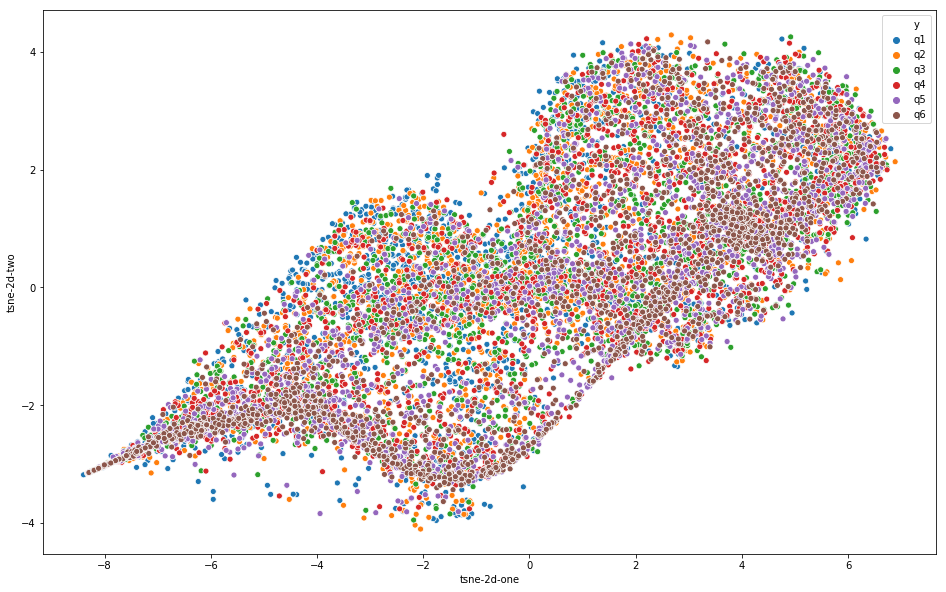

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df_subset = pd.DataFrame([])
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset["y"] = users_test["quintil_true"].values

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
#     palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full"
#     alpha=0.3
)

# plt.plot(tsne_results[:,0],tsne_results[:,1],'*')
# tsne_results.shape

In [37]:
data = pd.read_csv("s3://fda-labs/ltv-ml/Embedding/preproc_Doc2vec/train_doc2vec_10_20.csv")
summary = pd.read_csv("s3://fda-labs/ltv-ml/ML/sample_Preproc_MLA.csv")
data = pd.merge(data,summary,on="cust")

l_ = []

for i in range(6):
    l_.append(data.loc[data.quintil_true == "q"+str(i+1)].sample(n = 3000))

users_test = pd.concat(l_)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.011s...
[t-SNE] Computed neighbors for 18000 samples in 6.497s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sa

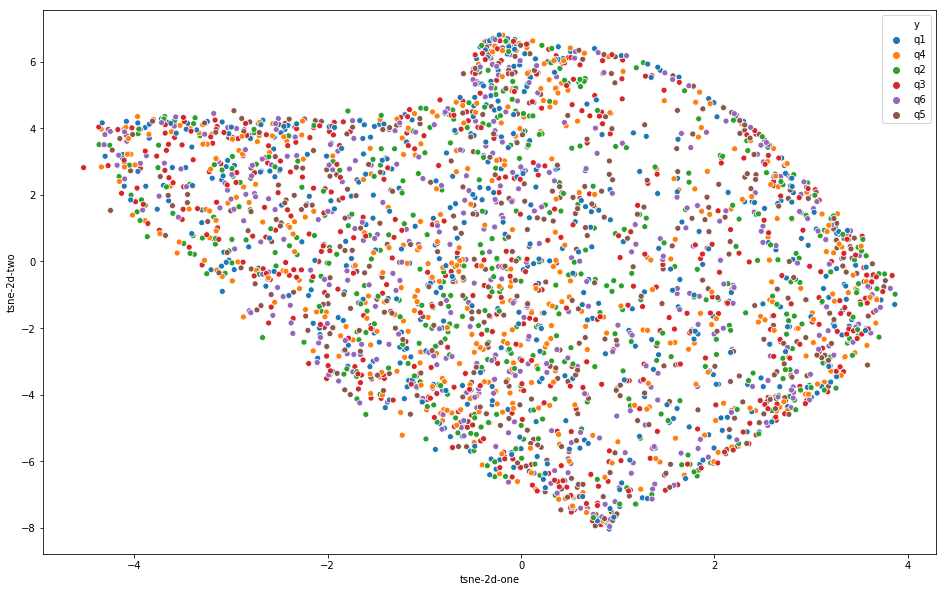

In [44]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(users_test[['doc2vec_10_20_0', 'doc2vec_10_20_1', 'doc2vec_10_20_2',
       'doc2vec_10_20_3', 'doc2vec_10_20_4', 'doc2vec_10_20_5',
       'doc2vec_10_20_6', 'doc2vec_10_20_7', 'doc2vec_10_20_8',
       'doc2vec_10_20_9']])

df_subset = pd.DataFrame([])
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset["y"] = users_test["quintil_true"]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
#     palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
#     alpha=0.3
)


In [47]:
data = pd.read_csv("s3://fda-labs/ltv-ml/Embedding/preproc_Doc2vec/train_doc2vec_20_12.csv")
cols = data.columns
summary = pd.read_csv("s3://fda-labs/ltv-ml/ML/sample_Preproc_MLA.csv")
data = pd.merge(data,summary,on="cust")


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.017s...
[t-SNE] Computed neighbors for 18000 samples in 16.448s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for s

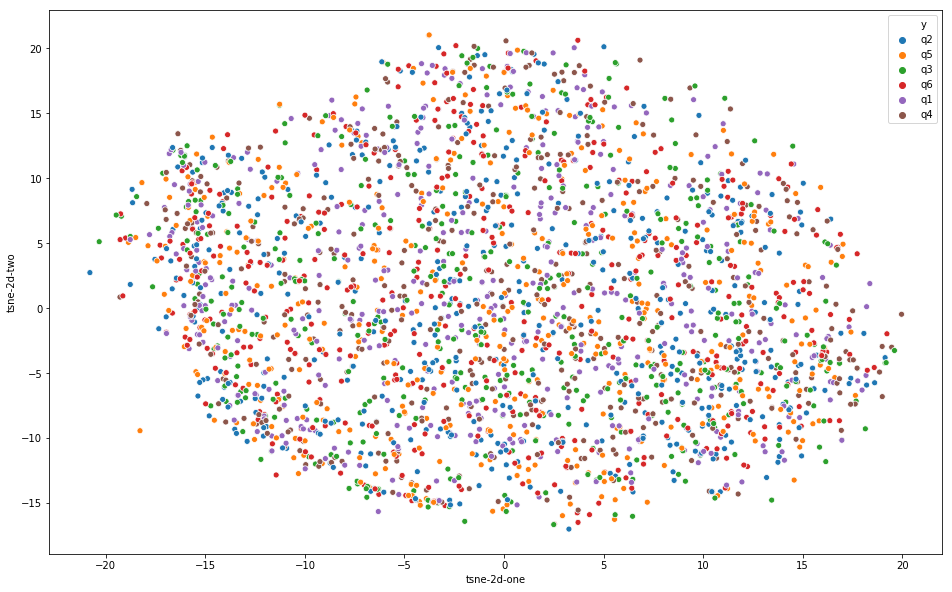

In [51]:
l_ = []

for i in range(6):
    l_.append(data.loc[data.quintil_true == "q"+str(i+1)].sample(n = 3000))

users_test = pd.concat(l_)

cols = [x for x in cols if(x not in 'cust')]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(users_test[cols])

df_subset = pd.DataFrame([])
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset["y"] = users_test["quintil_true"]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
#     palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full"
)


In [52]:
data = pd.read_csv("s3://fda-labs/ltv-ml/Embedding/preproc_Doc2vec/train_doc2vec_20_8.csv")
cols = data.columns
summary = pd.read_csv("s3://fda-labs/ltv-ml/ML/sample_Preproc_MLA.csv")
data = pd.merge(data,summary,on="cust")


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.017s...
[t-SNE] Computed neighbors for 18000 samples in 16.795s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for s

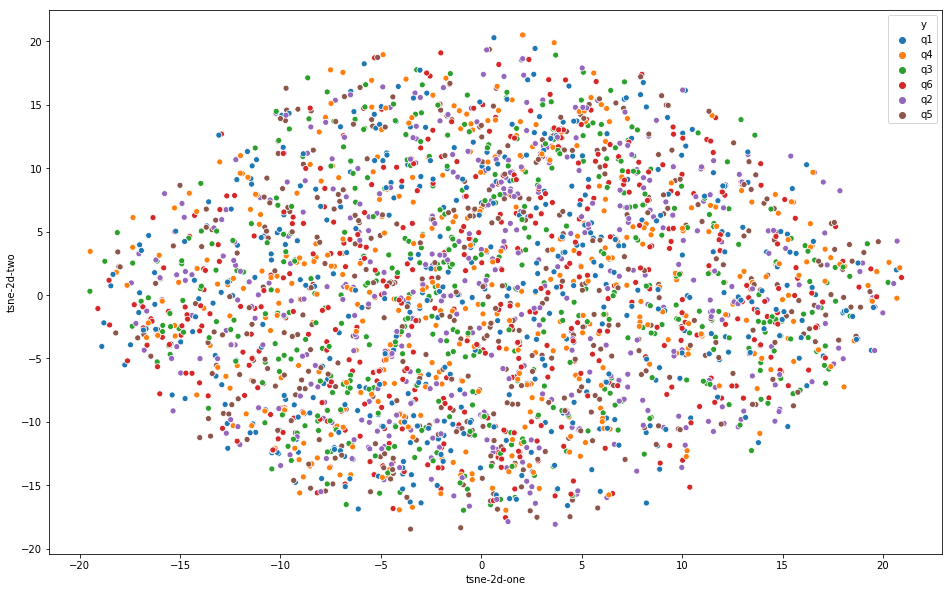

In [53]:
l_ = []

for i in range(6):
    l_.append(data.loc[data.quintil_true == "q"+str(i+1)].sample(n = 3000))

users_test = pd.concat(l_)

cols = [x for x in cols if(x not in 'cust')]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(users_test[cols])

df_subset = pd.DataFrame([])
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset["y"] = users_test["quintil_true"]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
#     palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full"
)


In [54]:
data = pd.read_csv("s3://fda-labs/ltv-ml/Embedding/preproc_Doc2vec/train_doc2vec_32_20.csv")
cols = data.columns
summary = pd.read_csv("s3://fda-labs/ltv-ml/ML/sample_Preproc_MLA.csv")
data = pd.merge(data,summary,on="cust")


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.026s...
[t-SNE] Computed neighbors for 18000 samples in 21.911s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for s

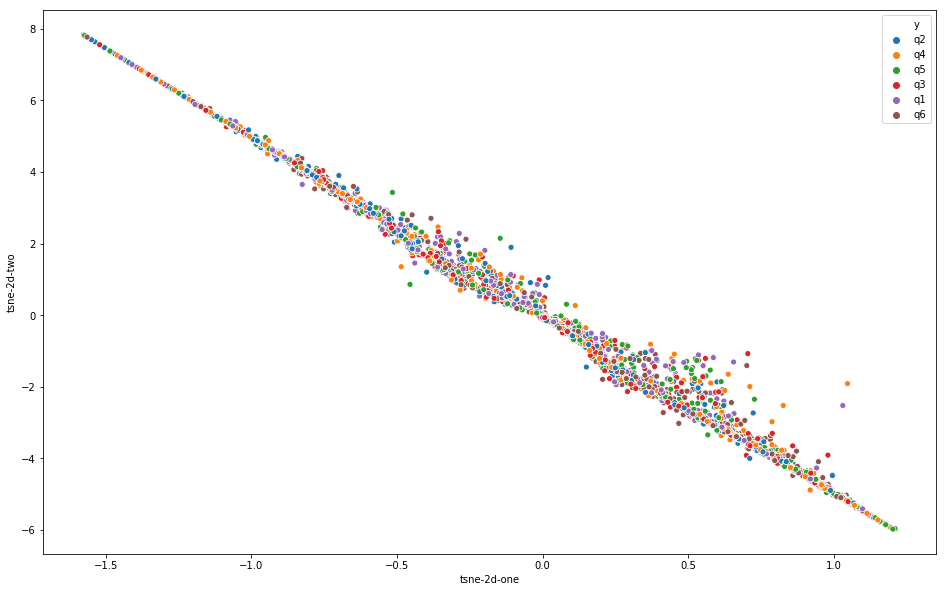

In [55]:
l_ = []

for i in range(6):
    l_.append(data.loc[data.quintil_true == "q"+str(i+1)].sample(n = 3000))

users_test = pd.concat(l_)

cols = [x for x in cols if(x not in 'cust')]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(users_test[cols])

df_subset = pd.DataFrame([])
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset["y"] = users_test["quintil_true"]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
#     palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full"
)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.017s...
[t-SNE] Computed neighbors for 18000 samples in 15.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for s

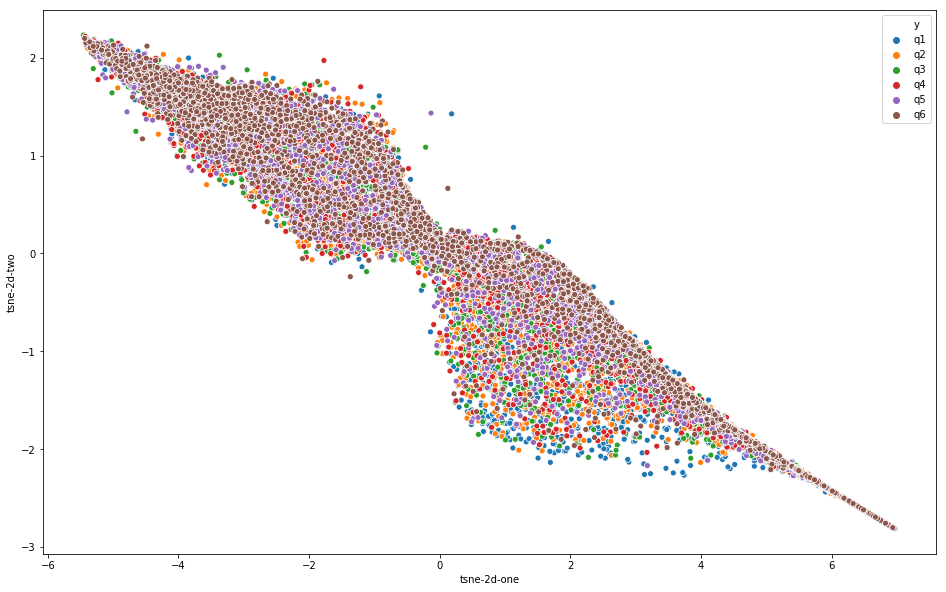

In [72]:
data = pd.read_csv("s3://fda-labs/ltv-ml/Embedding/preproc_Doc2vec/test_doc2vec_20_20.csv")
cols = data.columns
summary = pd.read_csv('s3://fda-labs/ltv-ml/ML/preproc_data_test.csv.gzip')
data = pd.merge(data,summary,on="cust")

l_ = []

for i in range(6):
    l_.append(data.loc[data.quintil_true == "q"+str(i+1)].sample(n = 3000))

users_test = pd.concat(l_)

cols = [x for x in cols if(x not in 'cust')]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(users_test[cols])

df_subset = pd.DataFrame([])
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset["y"] = users_test["quintil_true"].values

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
#     palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full"
)


In [60]:
df_subset.shape

(18000, 3)

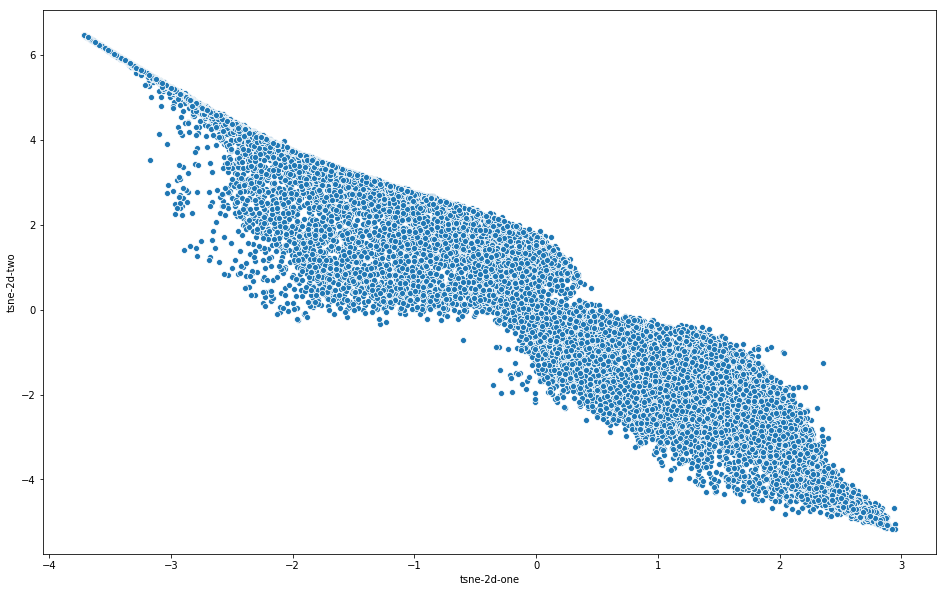

In [66]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
#     hue="y",
#     palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full"
)